## Setup

In [87]:
import anndata
import numpy as np
import pandas as p
import seaborn as sns
from scipy import stats
import liana as li
import scanpy as sc
import cell2cell as c2c
import decoupler as dc # needed for pathway analysis
from collections import defaultdict
import pickle
import torch
import io
import plotnine as p9
import decoupler as dc # needed for pathway analysis
#from statannotations.Annotator import Annotator
from liana.method import singlecellsignalr, connectome, cellphonedb, natmi, logfc, cellchat, geometric_mean
import os
import omnipath as op
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 80, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.9.2
scanpy      1.9.6
-----
PIL                 10.4.0
asttokens           NA
attr                23.2.0
backcall            0.2.0
brotli              1.1.0
cell2cell           0.7.4
certifi             2024.06.02
cffi                1.16.0
charset_normalizer  3.3.2
comm                0.2.2
cycler              0.12.1
cython_runtime      NA
dateutil            2.9.0
debugpy             1.8.2
decorator           5.1.1
decoupler           1.6.0
docrep              0.3.2
executing           2.0.1
get_annotations     NA
h5py                3.11.0
idna                3.7
importlib_resources NA
inflect             NA
ipykernel           6.29.5
jedi                0.19.1
joblib              1.4.2
kiwisolver          1.4.5
kneed               0.8.5
liana               1.2.1
llvmlite            0.41.1
matplotlib          3.7.5
matplotlib_inline   0.1.7
mizani              0.9.3
more_itertools      10.3.0
mpl_toolkits        NA
mudata              0.2.3
natsort             8.

In [3]:

def unpickle_gpu_tensor(filepath: str, processing_unit: str):
    '''
    Function to load a pickled tensor file created using cell2cell with gpu acceleration

    filepath: str = path of the tensor file
    processing_unit: str = processing_unit used in the current environment to load the file onto (either "gpu" or "cpu")
    '''
    class CPU_Unpickler(pickle.Unpickler):
        def find_class(self, module, name):
            if module == 'torch.storage' and name == '_load_from_bytes':
                return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
            else: return super().find_class(module, name)

    processing_unit_values = ['cpu', 'gpu']
    if processing_unit == 'cpu':
        with open(filepath, 'rb') as f:
            tensor = CPU_Unpickler(f).load()
    elif processing_unit == 'gpu':
        with open(filepath, 'rb') as f:
            tensor = pickle.load(f)
    else:
        raise ValueError(f'accelerator must be one of {processing_unit_values}')
    return tensor

In [4]:
data_dir = os.path.join(os.getcwd(), '.data')
os.makedirs(data_dir, exist_ok=True)
os.listdir(data_dir)

['initial_tensor.pkl',
 'final_tensor.pkl',
 'anndata_liana.h5ad',
 'final_tensor_compartment.pkl',
 'final_tensor_compartment_healthy.pkl',
 'initial_tensor_compartment.pkl',
 'Marburg_cell_states_locked_ctl240709.raw.h5ad',
 'final_tensor_compartment_COPD.pkl']

In [5]:
adata_path = os.path.join(data_dir, 'Marburg_cell_states_locked_ctl240709.raw.h5ad')
adata_all = sc.read_h5ad(adata_path)
adata_all

AnnData object with n_obs × n_vars = 97573 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', 'IAV_score', 'group', 'Viral_score', 'cell_type', 'cell_states', 'leiden', 'cell_compartment', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'viral_counts', 'infected_status', 'seed_labels', 'batch-scANVI'
    var: 'mt', 'ribo'
    uns: 'cell_compartment_colors', 'cell_states_colors', 'disease_colors', 'group_colors', 'infection_colors'
    obsm: 'X_scANVI', 'X_umap'

In [10]:
sample_key = 'batch'
condition_key = 'infection'
groupby = 'cell_compartment'

In [11]:
context_dict = adata_all.obs[[sample_key, condition_key]].drop_duplicates()
context_dict = dict(zip(context_dict[sample_key], context_dict[condition_key]))
context_dict = defaultdict(lambda: 'Unknown', context_dict)
# Generate color by severity for each sample
condition_colors = c2c.plotting.aesthetics.get_colors_from_labels(['CTRL', 'IAV'], cmap='plasma')

# Map these colors to each sample name
color_dict = {k : condition_colors[v] for k, v in context_dict.items()}

col_colors = pd.Series(color_dict)
col_colors = col_colors.to_frame()
col_colors.columns = ['infection status']
context_dict

defaultdict(<function __main__.<lambda>()>,
            {'ST07_CSE_CTRL': 'CTRL',
             'CSE_06_CRTL': 'CTRL',
             'GER14_CRTL': 'CTRL',
             'GnR08_CTRL': 'CTRL',
             'GER12_CTRL': 'CTRL',
             'GER02_CTRL': 'CTRL',
             'ST10_GnR_IAV': 'IAV',
             'GnR_07_IAV': 'IAV',
             'CHE01_IAV': 'IAV',
             'CHE02_IAV': 'IAV',
             'CHE03_IAV': 'IAV',
             'CSE03_IAV': 'IAV',
             'ST09_CSE_IAV': 'IAV',
             'GnR_07_CTRL': 'CTRL',
             'CHE01_CTRL': 'CTRL',
             'CHE02_CTRL': 'CTRL',
             'CHE03_CTRL': 'CTRL',
             'CSE03_CTRL': 'CTRL',
             'ST08_GnR_CTRL': 'CTRL',
             'CSE_06_IAV': 'IAV',
             'GER14_IAV': 'IAV',
             'GnR08_IAV': 'IAV',
             'GER12_IAV': 'IAV',
             'GER02_IAV': 'IAV'})

In [12]:
# load PROGENy pathways
net = dc.get_progeny(organism='human', top=5000)
# load full list of ligand-receptor pairs
lr_pairs = li.resource.select_resource('consensus')

## Analysis

### Healthy

In [6]:
# Path
file_name = 'final_tensor_compartment_healthy.pkl'
file_path = os.path.join(data_dir, file_name)
# Load
tensor_healthy = unpickle_gpu_tensor(file_path, 'cpu')
tensor_healthy

In [14]:
factors_healthy = tensor_healthy.factors
factors_healthy.keys()

odict_keys(['Contexts', 'Ligand-Receptor Pairs', 'Sender Cells', 'Receiver Cells'])

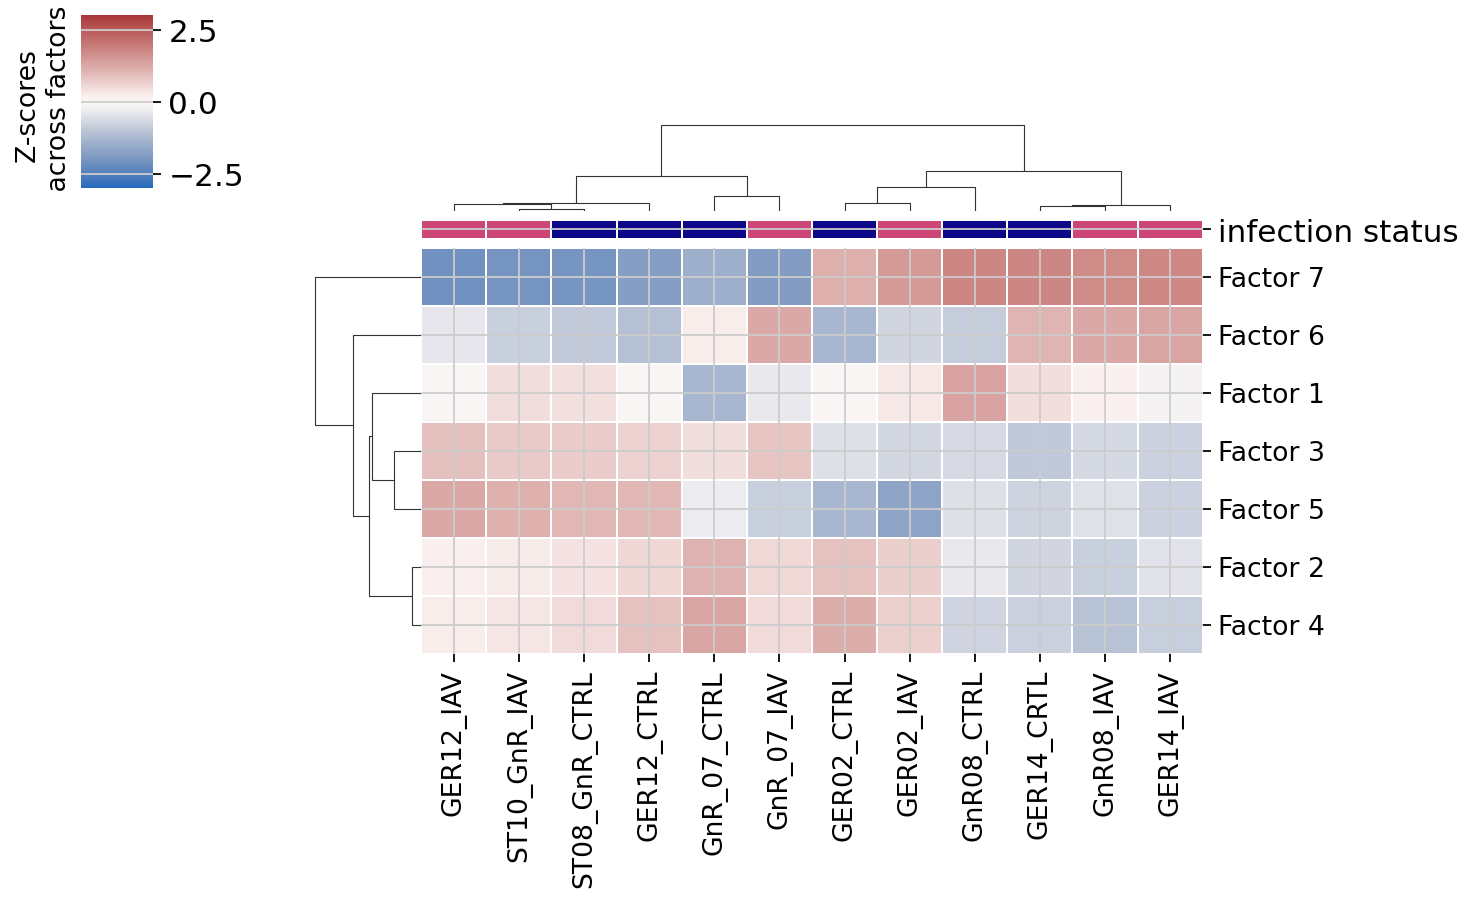

In [21]:
c2c.plotting.loading_clustermap(factors_healthy['Contexts'],
                                use_zscore=True, # Whether standardizing the loadings across factors
                                col_colors=col_colors, # Change this to color by other properties
                                figsize=(9, 6),
                                dendrogram_ratio=0.3,
                                cbar_fontsize=12,
                                tick_fontsize=12
                                )

(<Figure size 640x960 with 8 Axes>,
 array([[<Axes: title={'center': 'Factor 1'}, ylabel='Context Loadings'>,
         <Axes: title={'center': 'Factor 2'}, ylabel=' '>],
        [<Axes: title={'center': 'Factor 3'}, ylabel='Context Loadings'>,
         <Axes: title={'center': 'Factor 4'}, ylabel=' '>],
        [<Axes: title={'center': 'Factor 5'}, ylabel='Context Loadings'>,
         <Axes: title={'center': 'Factor 6'}, ylabel=' '>],
        [<Axes: title={'center': 'Factor 7'}, ylabel='Context Loadings'>,
         <Axes: >]], dtype=object))

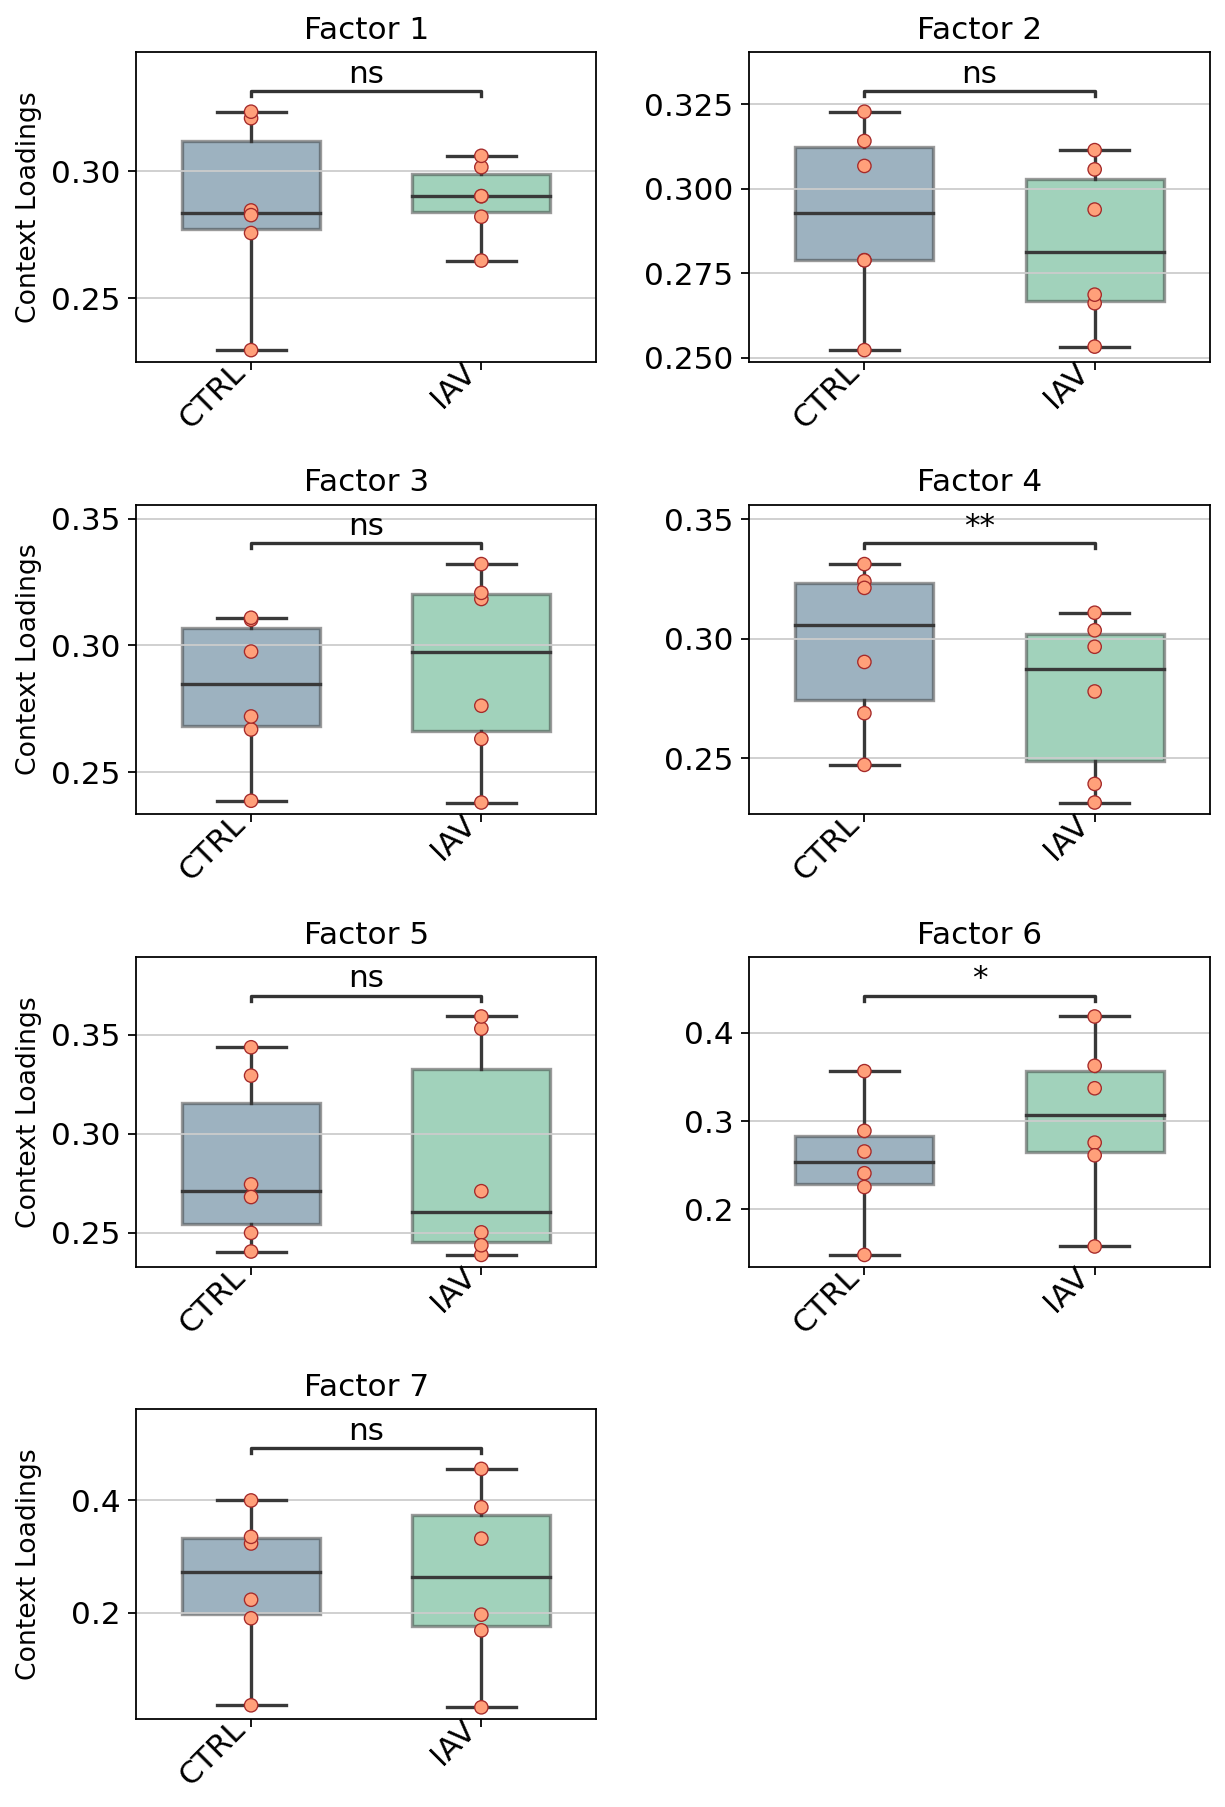

In [22]:
c2c.plotting.factor_plot.context_boxplot(factors_healthy['Contexts'],
                            metadict=context_dict,
                            group_label_rotation= 45,
                            nrows=4,
                            figsize=(8, 12),
                            group_order=['CTRL', 'IAV'],
                            statistical_test='t-test_paired',
                            pval_correction='BH',
                            verbose=False,
                            cmap='viridis',
                            ylabel="Context Loadings",
                            text_format='star'
                            )

(<Figure size 1920x1920 with 9 Axes>,
 array([[<Axes: title={'center': 'Factor 1'}>,
         <Axes: title={'center': 'Factor 2'}>,
         <Axes: title={'center': 'Factor 3'}>],
        [<Axes: title={'center': 'Factor 4'}>,
         <Axes: title={'center': 'Factor 5'}>,
         <Axes: title={'center': 'Factor 6'}>],
        [<Axes: title={'center': 'Factor 7'}>, <Axes: >, <Axes: >]],
       dtype=object))

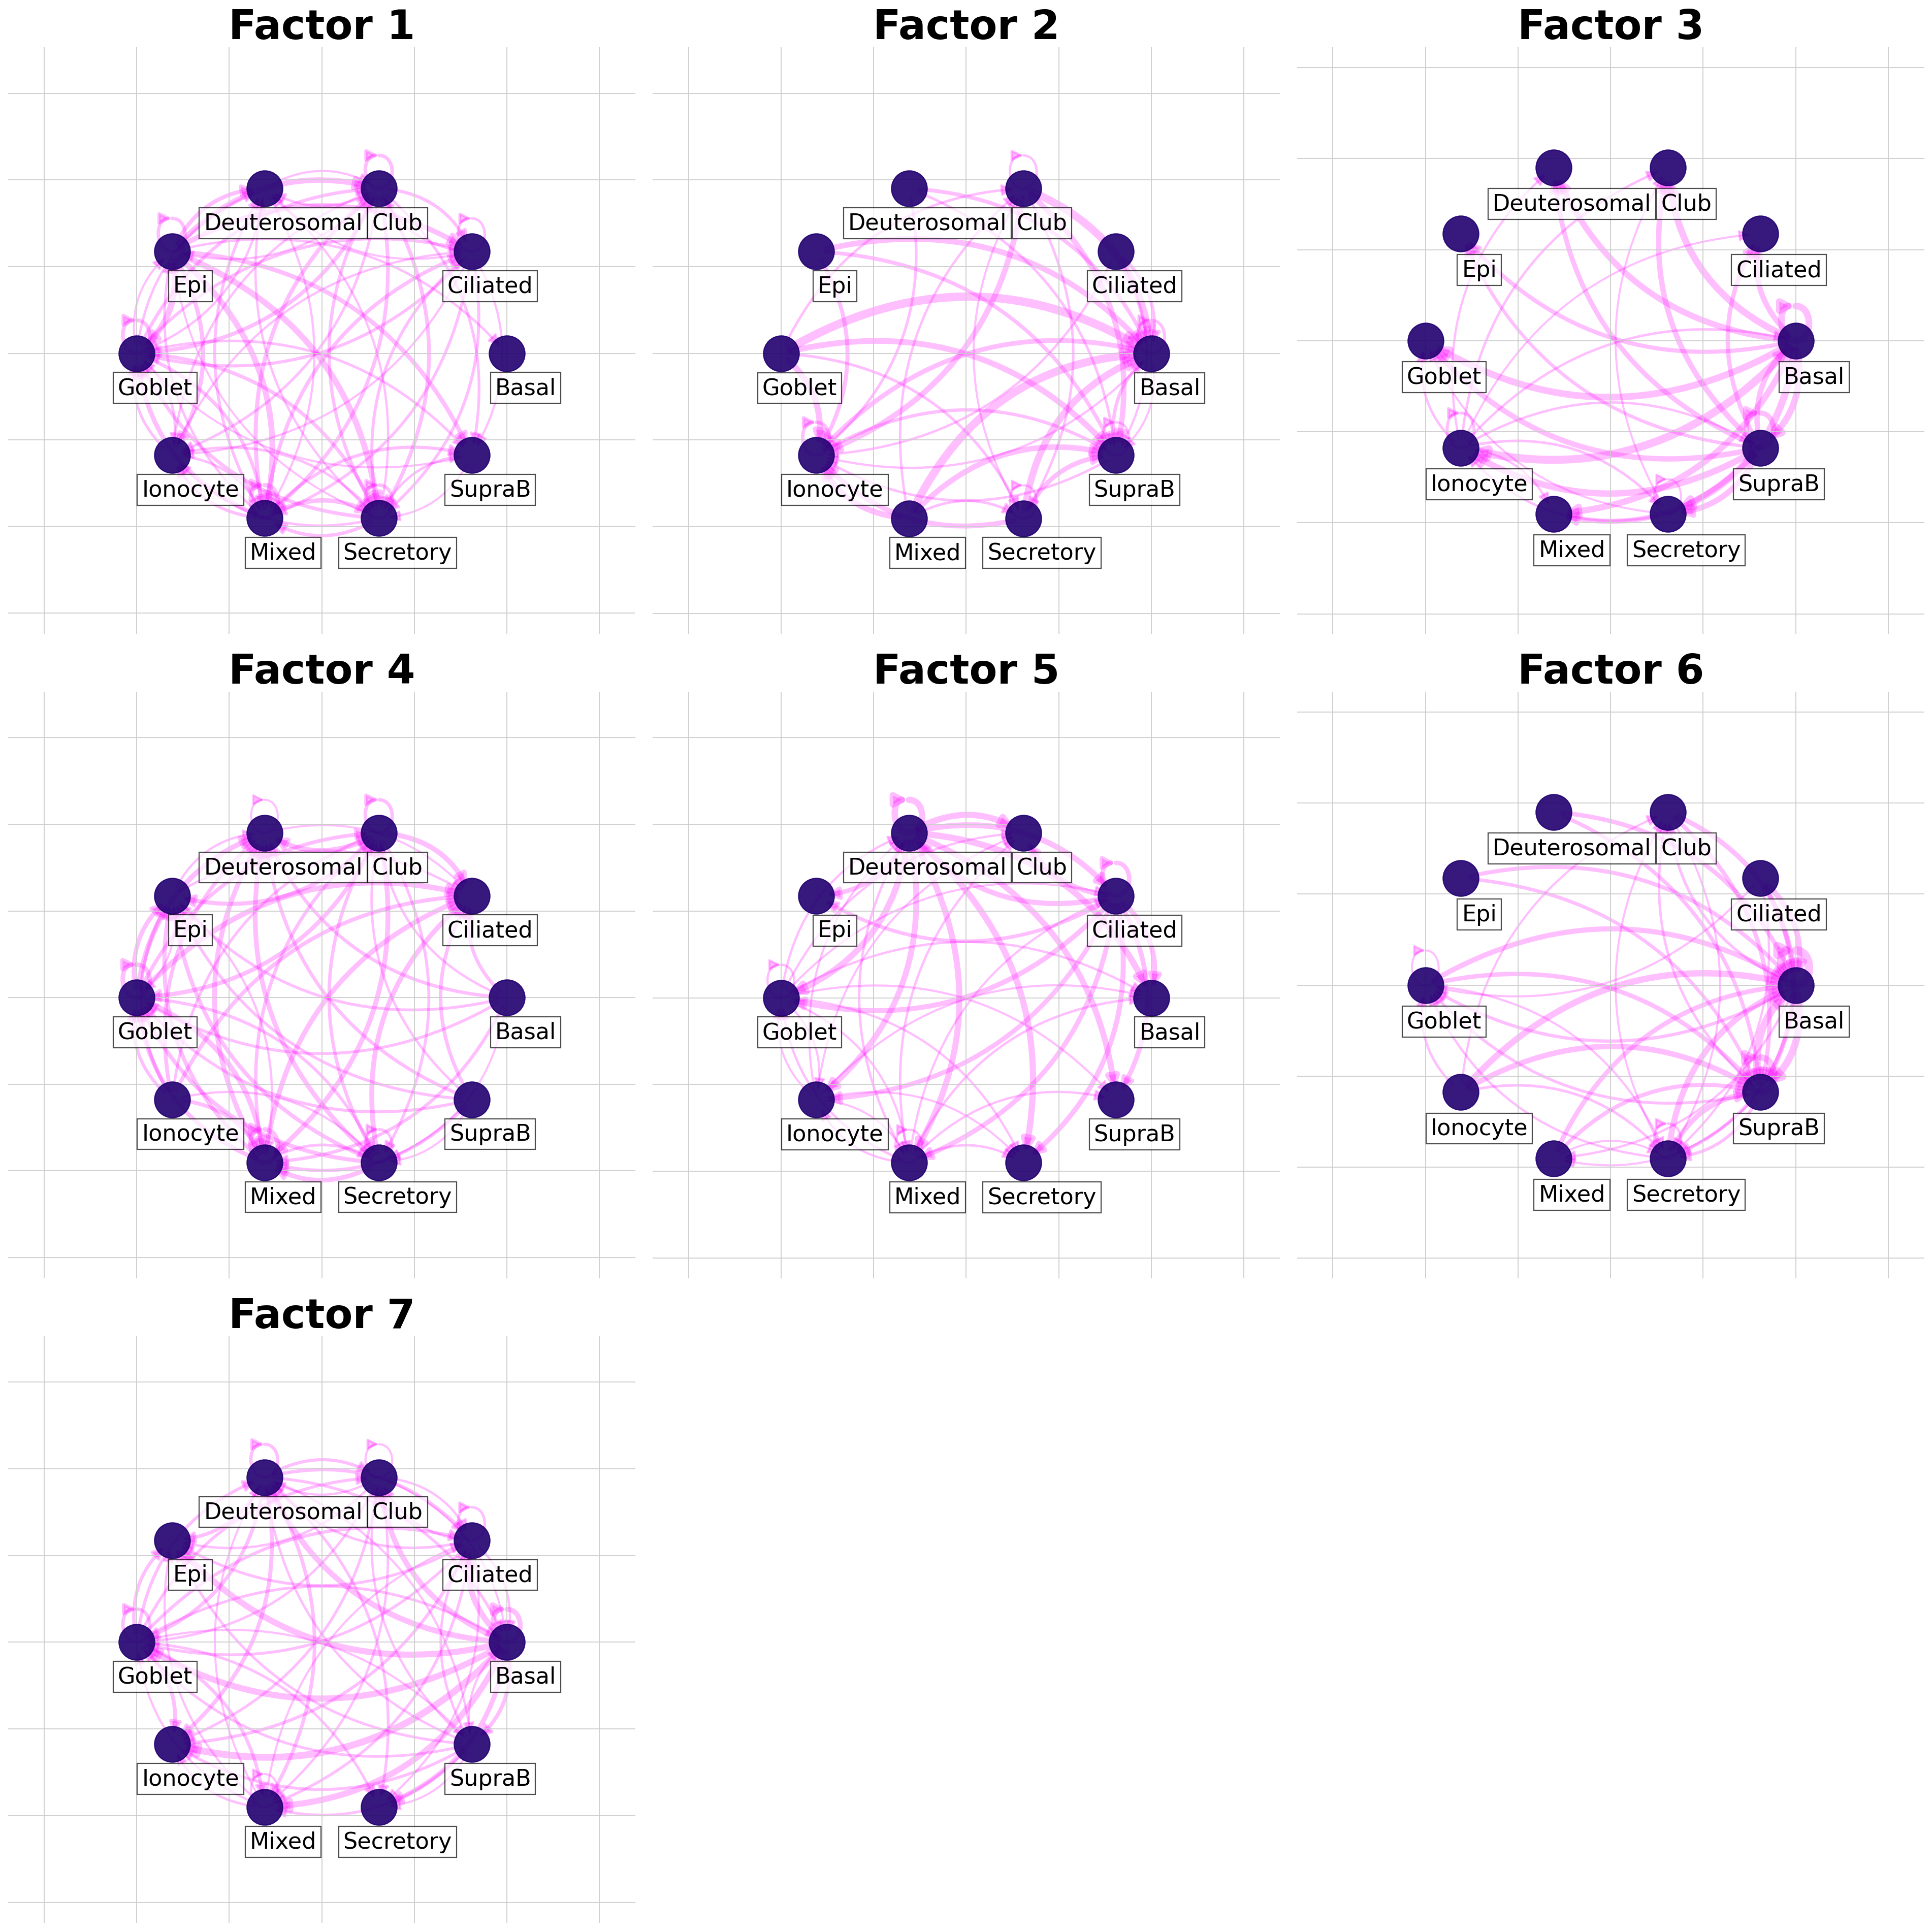

In [23]:
c2c.plotting.ccc_networks_plot(factors_healthy,
                               included_factors=['Factor 1','Factor 2', 'Factor 3','Factor 4','Factor 5', 'Factor 6', 'Factor 7'],
                               network_layout='circular',
                               ccc_threshold=0.07, # Only important communication
                               nrows=3,
                               panel_size=(8, 8), # This changes the size of each figure panel.
                              )

In [29]:
lr_loadings_healthy = factors_healthy['Ligand-Receptor Pairs']
# load full list of ligand-receptor pairs
lr_pairs = li.resource.select_resource('consensus')
# generate ligand-receptor geneset
lr_progeny = li.rs.generate_lr_geneset(lr_pairs, net, lr_sep="^")
# run enrichment analysis
estimate_healthy, pvals_healthy = dc.run_ulm(lr_loadings_healthy.transpose(), lr_progeny, source="source", target="interaction", use_raw=False)

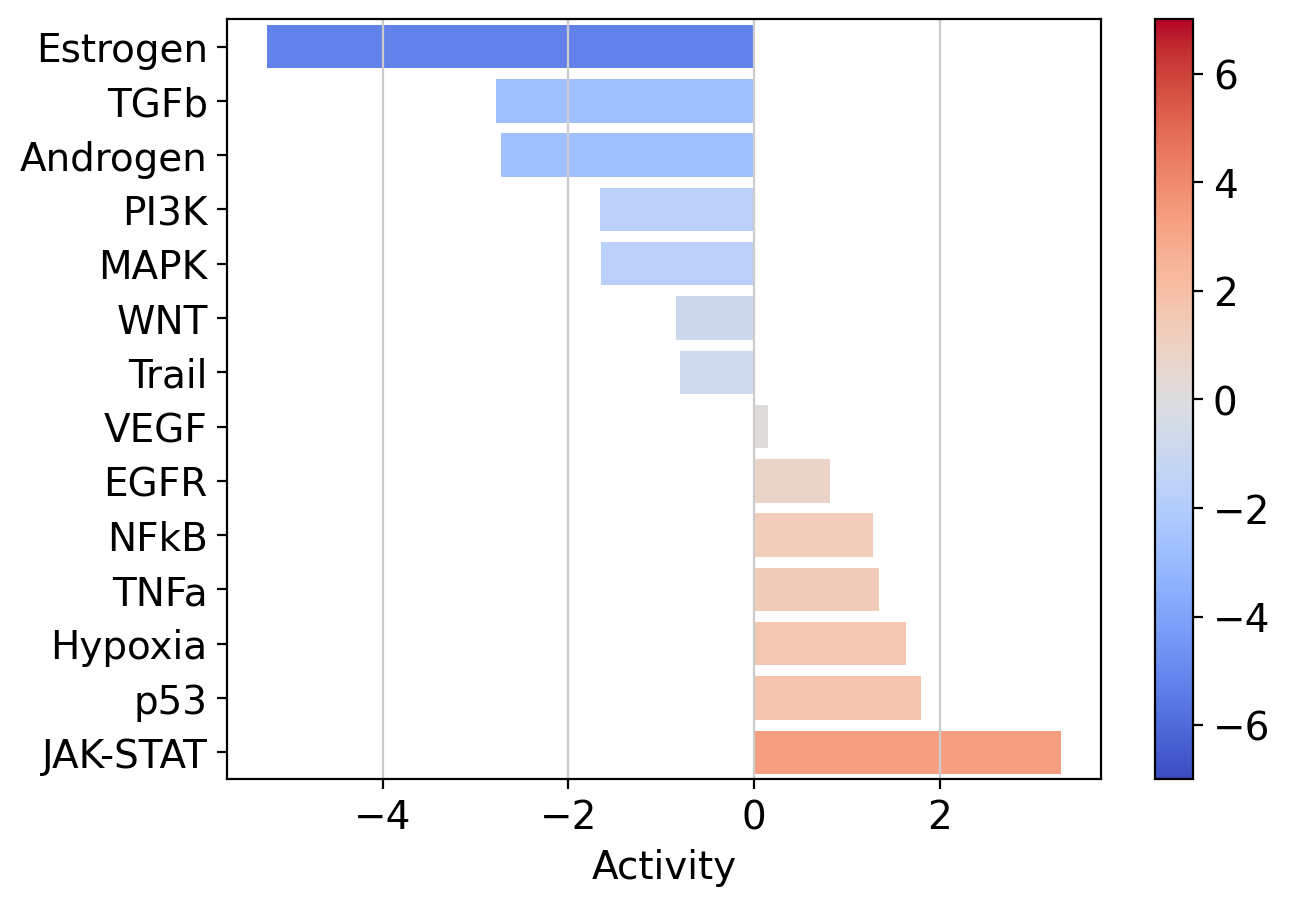

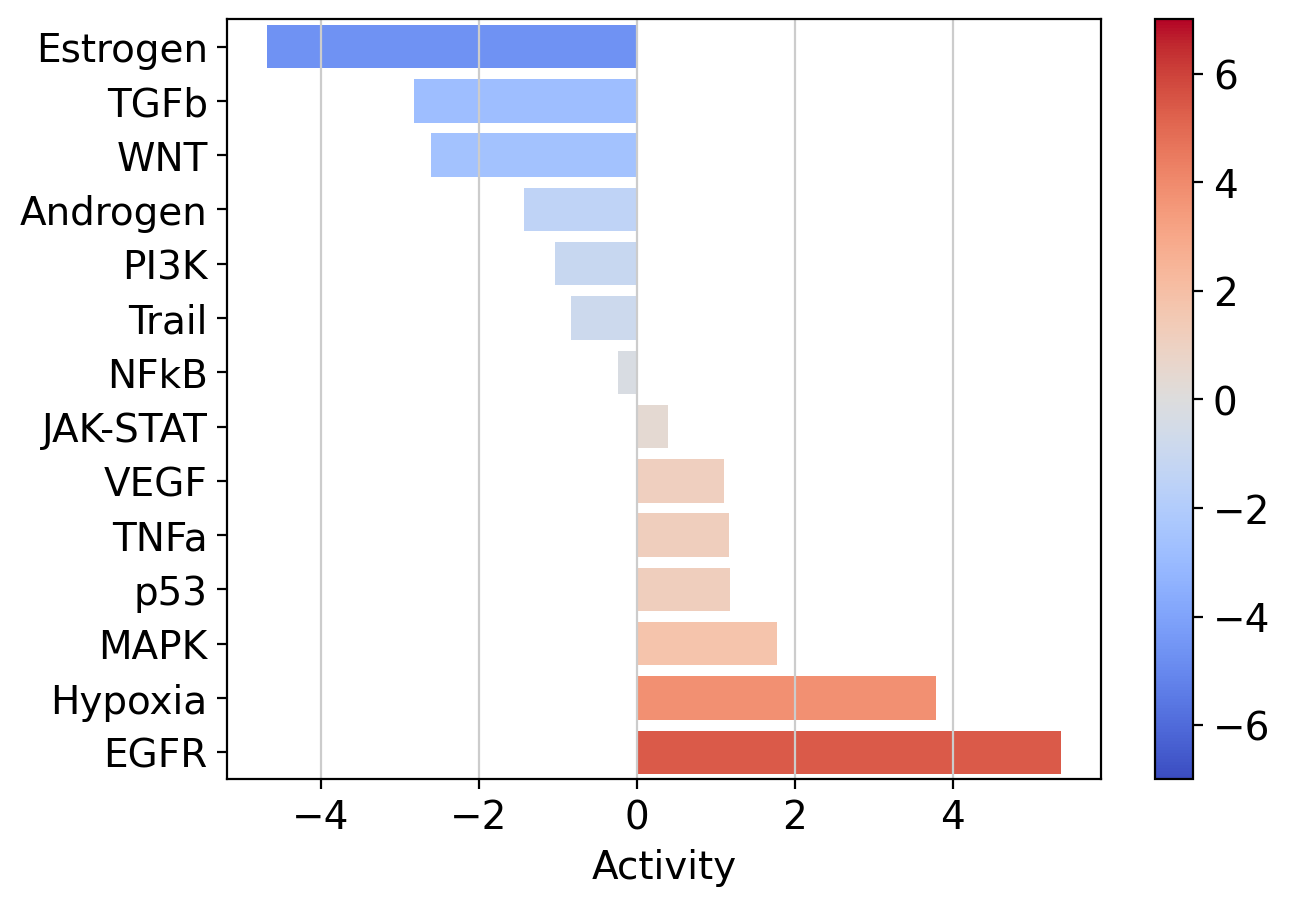

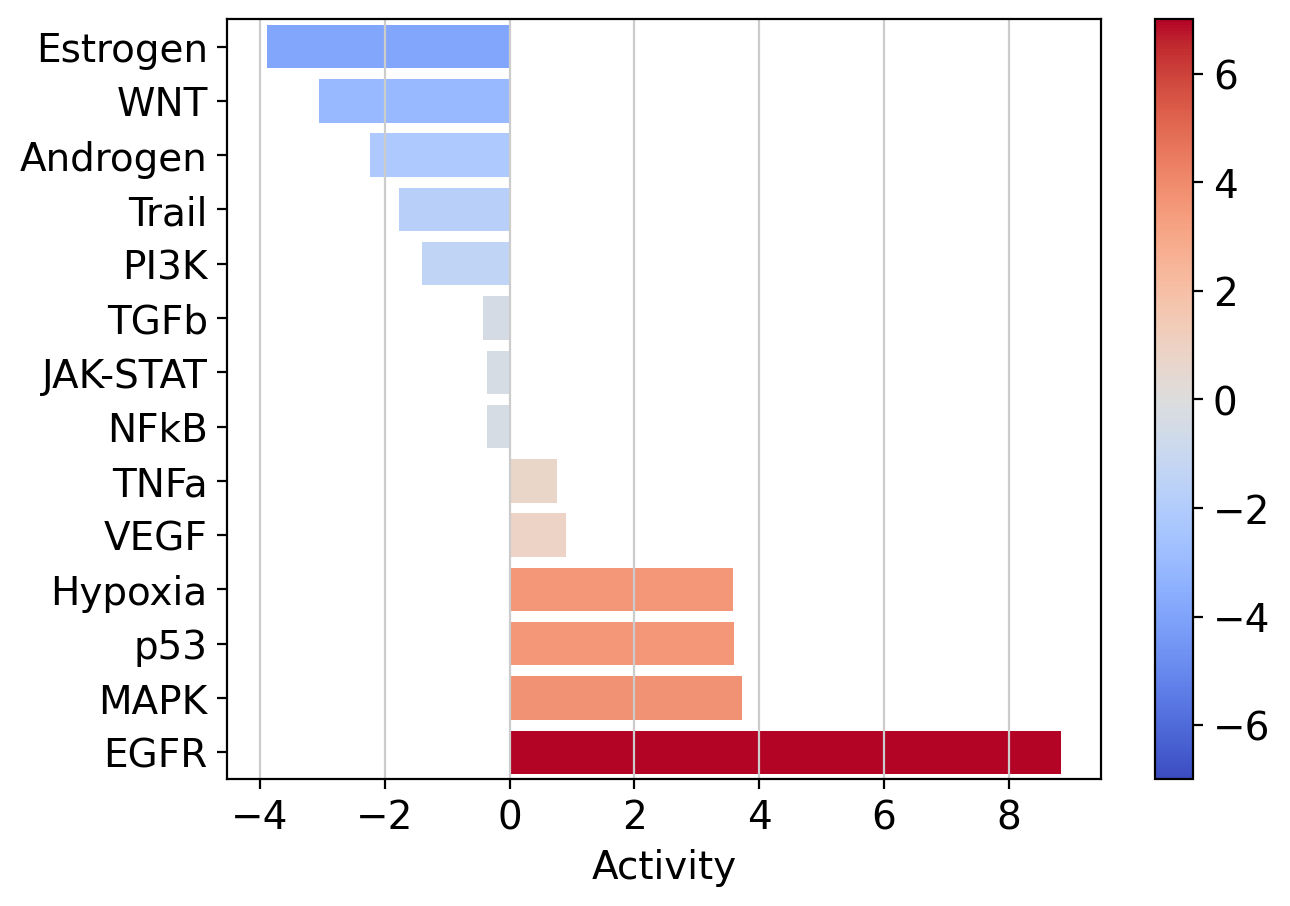

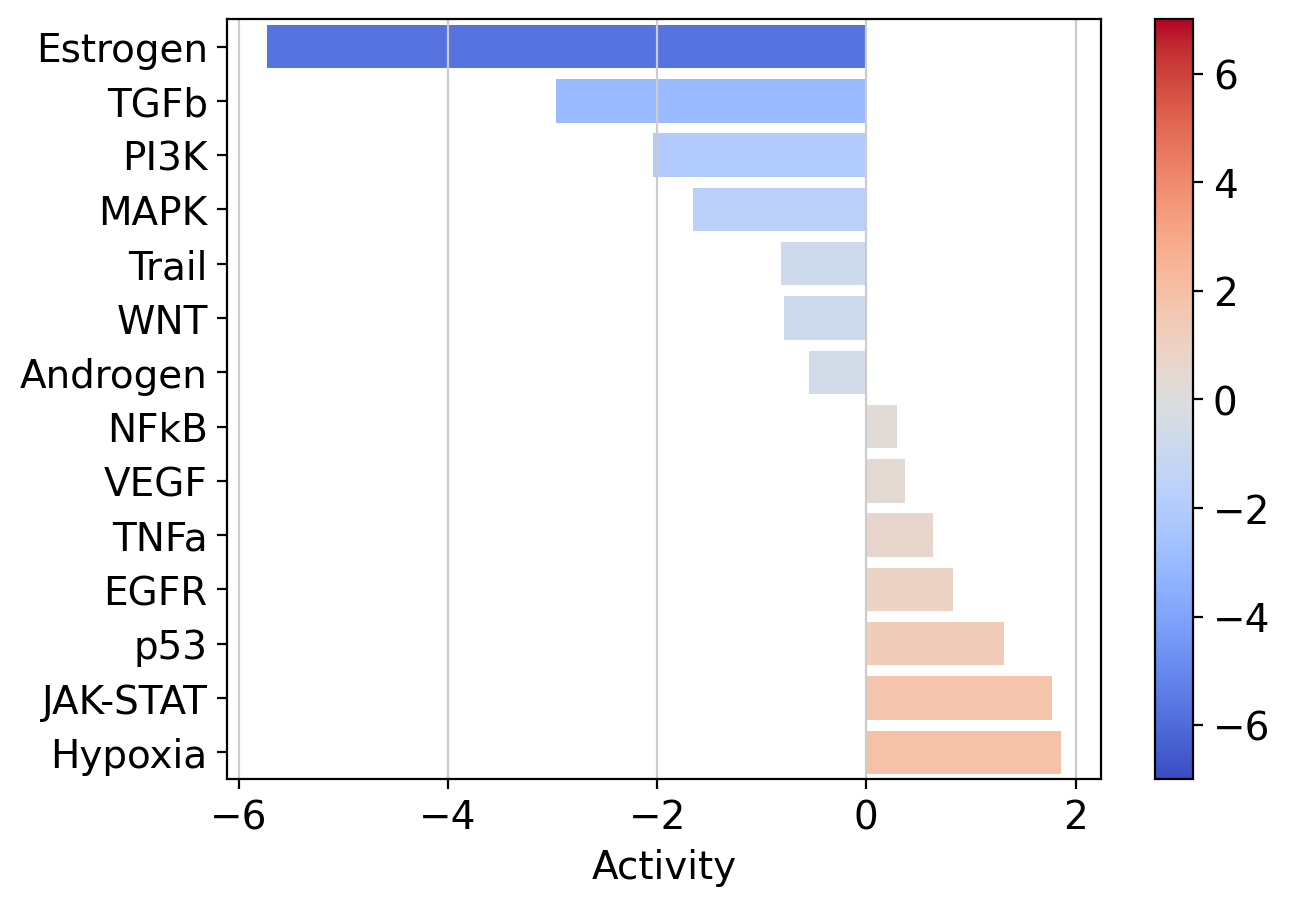

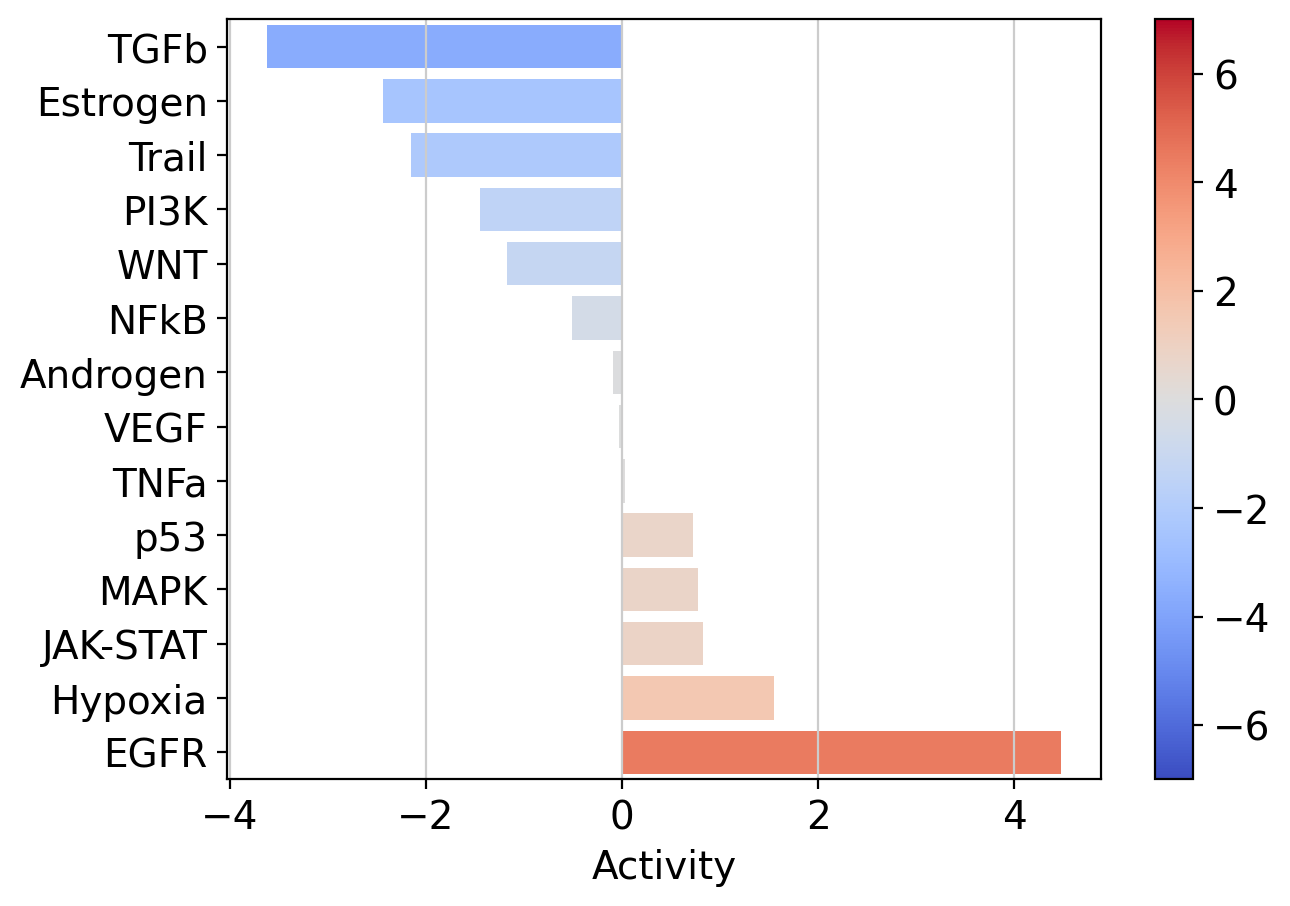

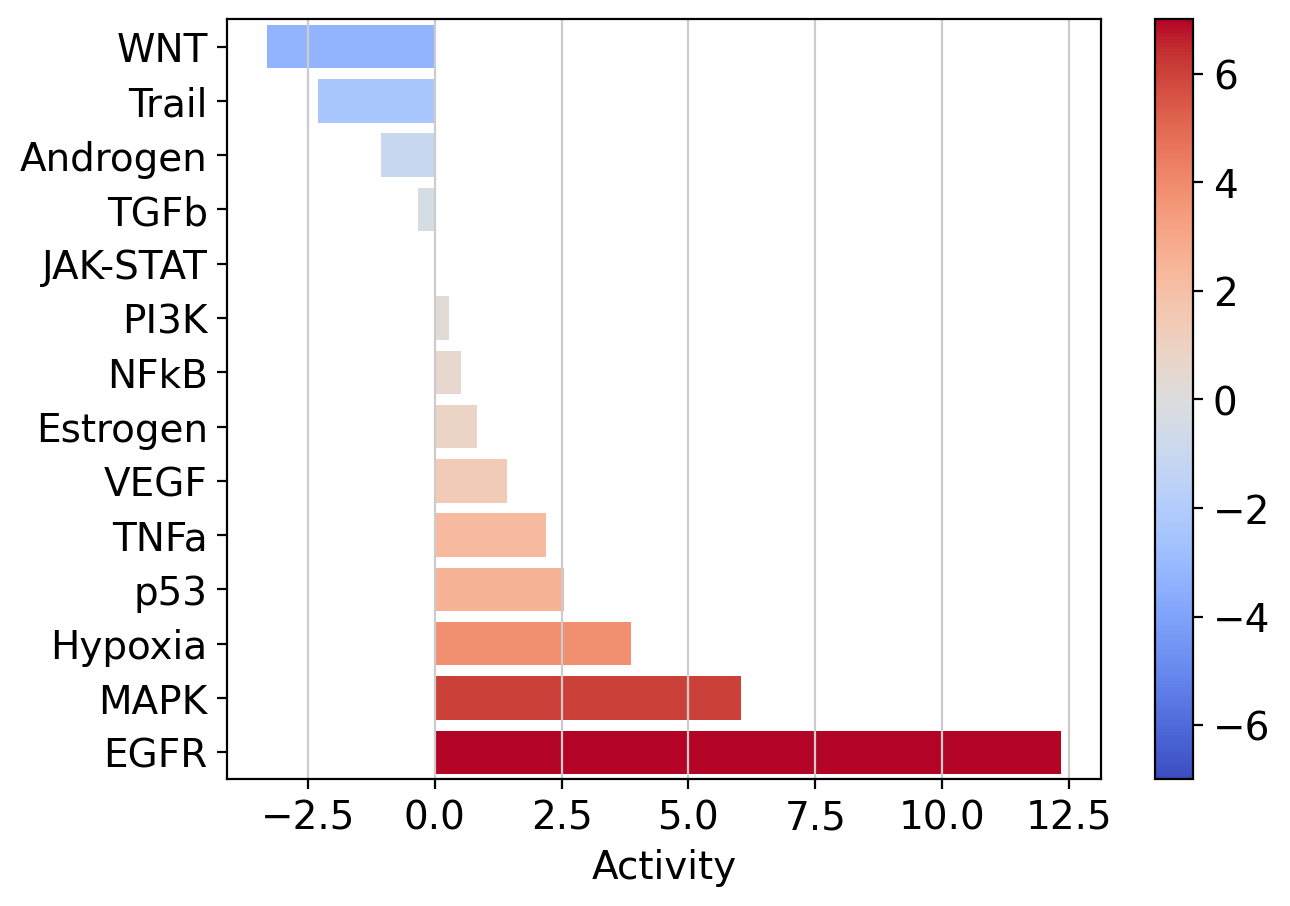

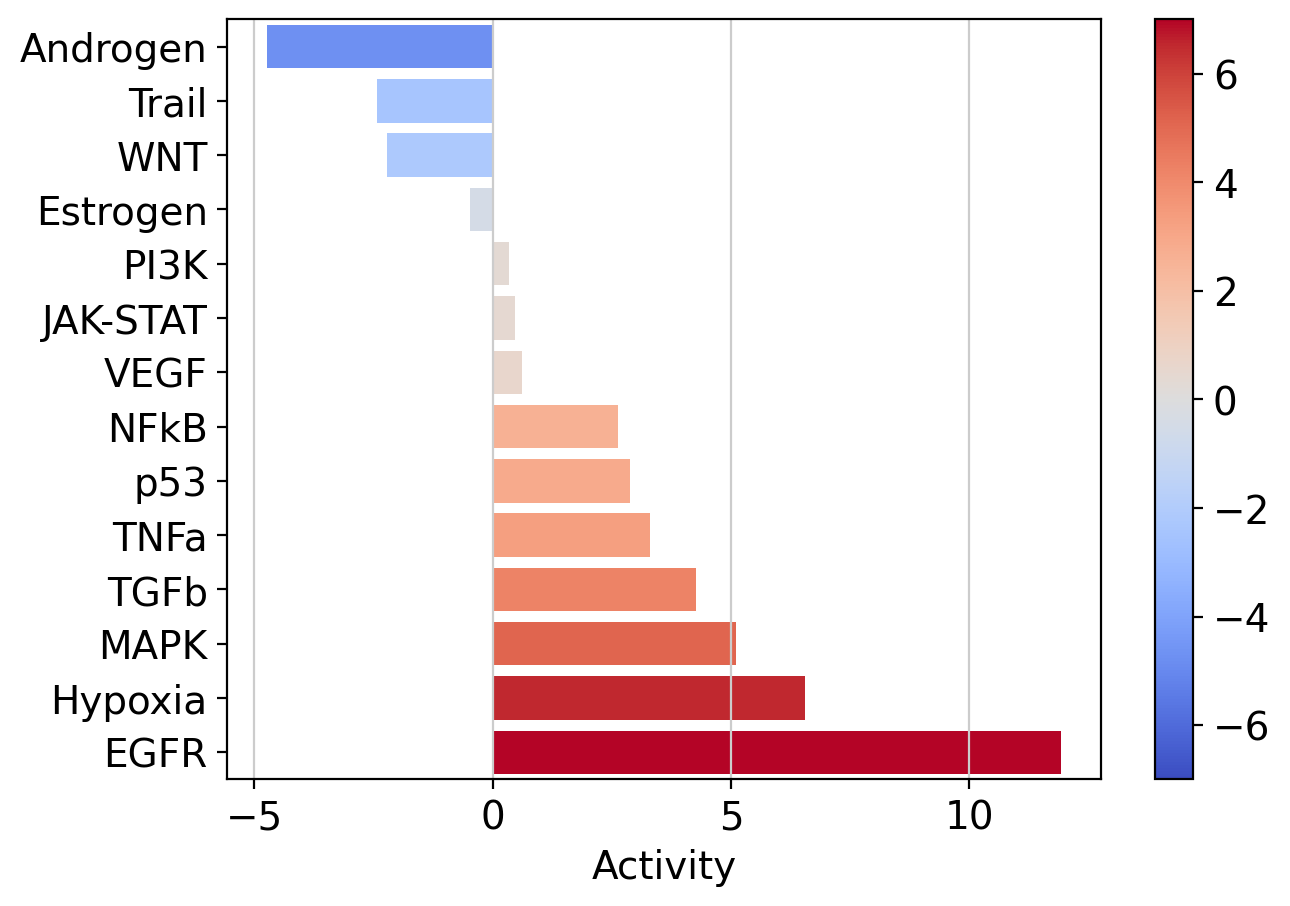

In [30]:
dc.plot_barplot(estimate_healthy, 'Factor 1', vertical=True, cmap='coolwarm', vmin=-7, vmax=7)
dc.plot_barplot(estimate_healthy, 'Factor 2', vertical=True, cmap='coolwarm', vmin=-7, vmax=7)
dc.plot_barplot(estimate_healthy, 'Factor 3', vertical=True, cmap='coolwarm', vmin=-7, vmax=7)
dc.plot_barplot(estimate_healthy, 'Factor 4', vertical=True, cmap='coolwarm', vmin=-7, vmax=7)
dc.plot_barplot(estimate_healthy, 'Factor 5', vertical=True, cmap='coolwarm', vmin=-7, vmax=7)
dc.plot_barplot(estimate_healthy, 'Factor 6', vertical=True, cmap='coolwarm', vmin=-7, vmax=7)
dc.plot_barplot(estimate_healthy, 'Factor 7', vertical=True, cmap='coolwarm', vmin=-7, vmax=7)

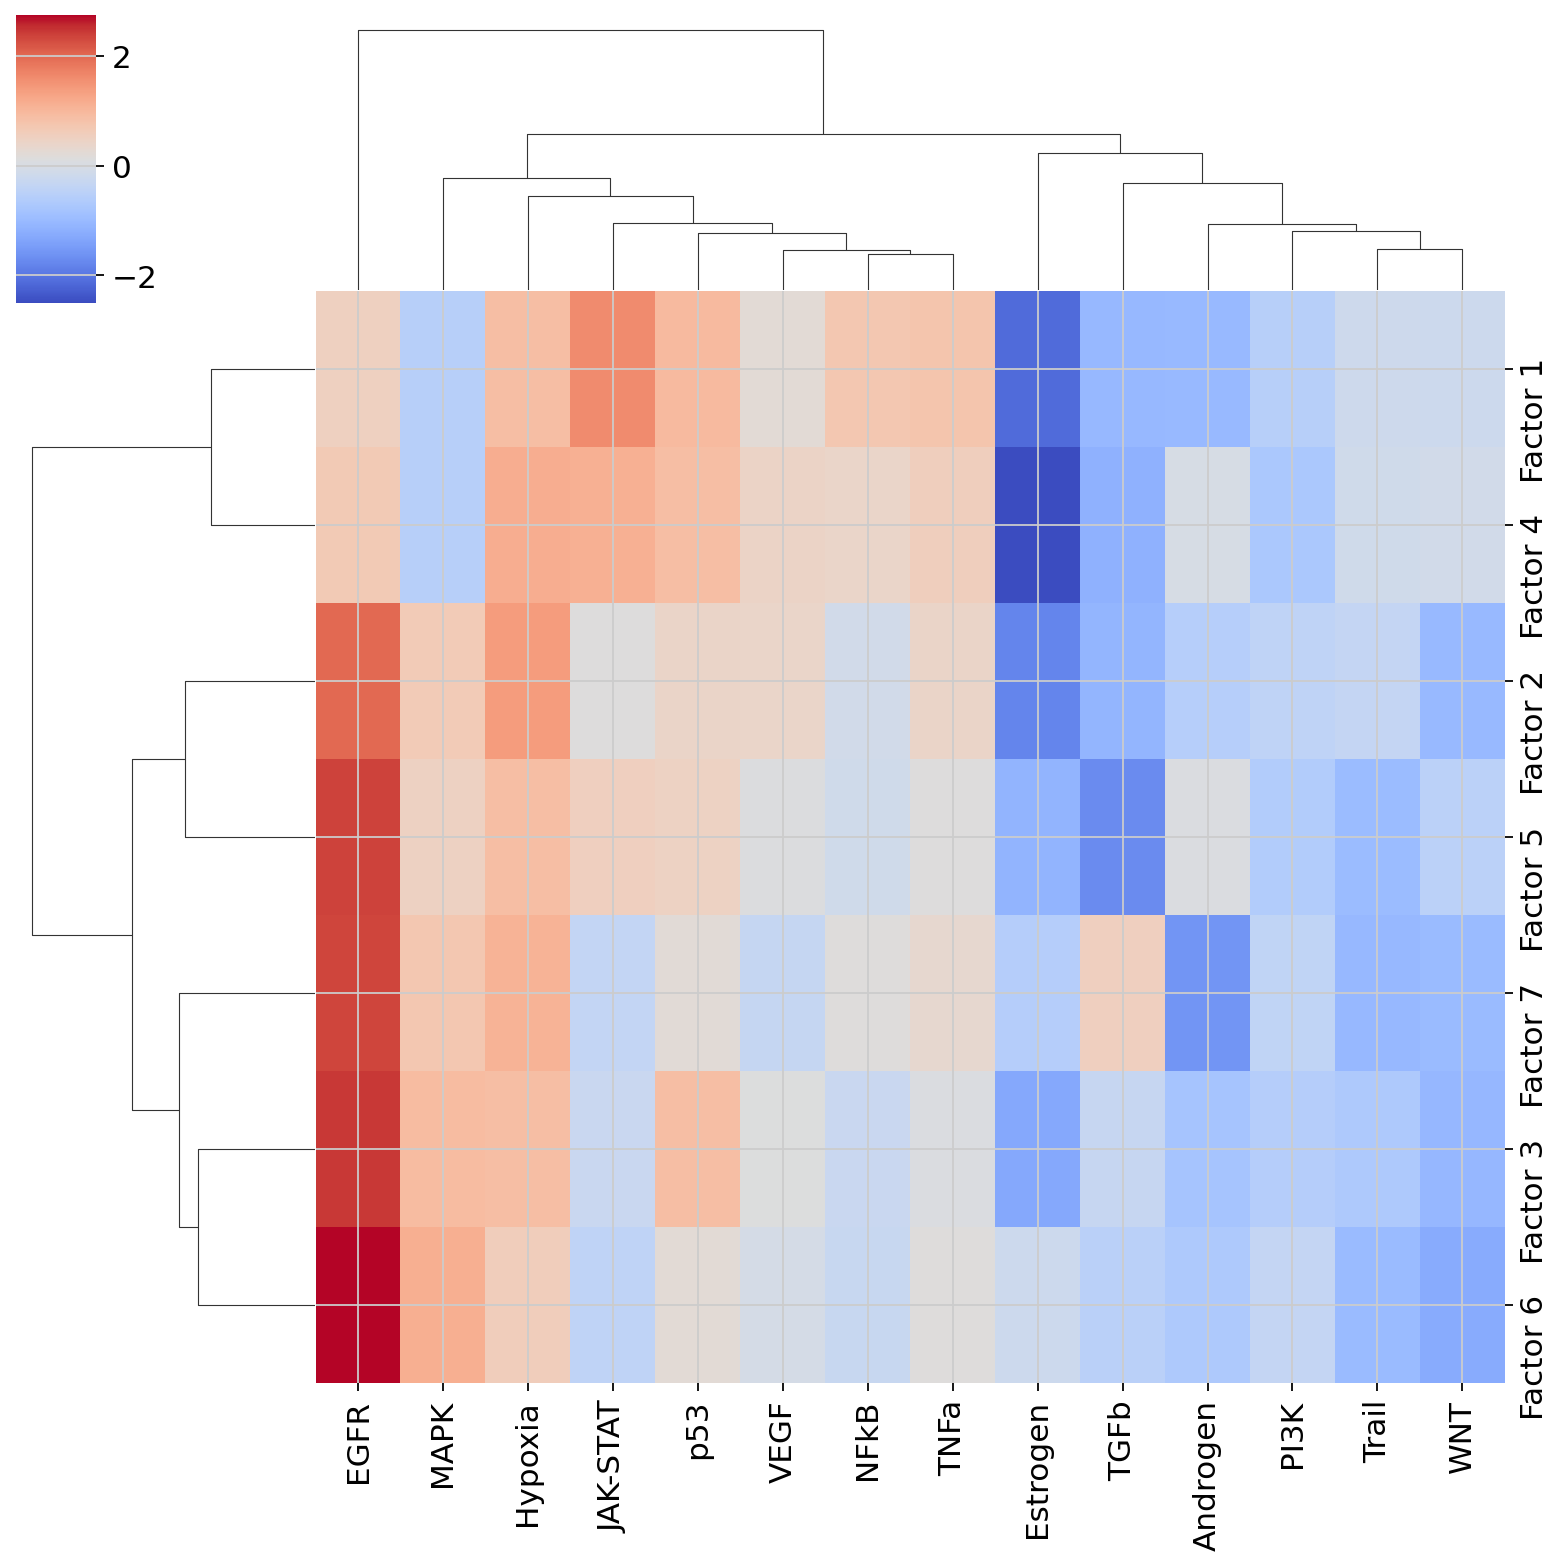

In [31]:
sns.clustermap(estimate_healthy, xticklabels=estimate_healthy.columns, cmap='coolwarm', z_score=4)

/home/ceger/miniforge3/envs/liana_c2c-env/lib/python3.8/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 4 rows containing missing values.
/home/ceger/miniforge3/envs/liana_c2c-env/lib/python3.8/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_label : Removed 25 rows containing missing values.


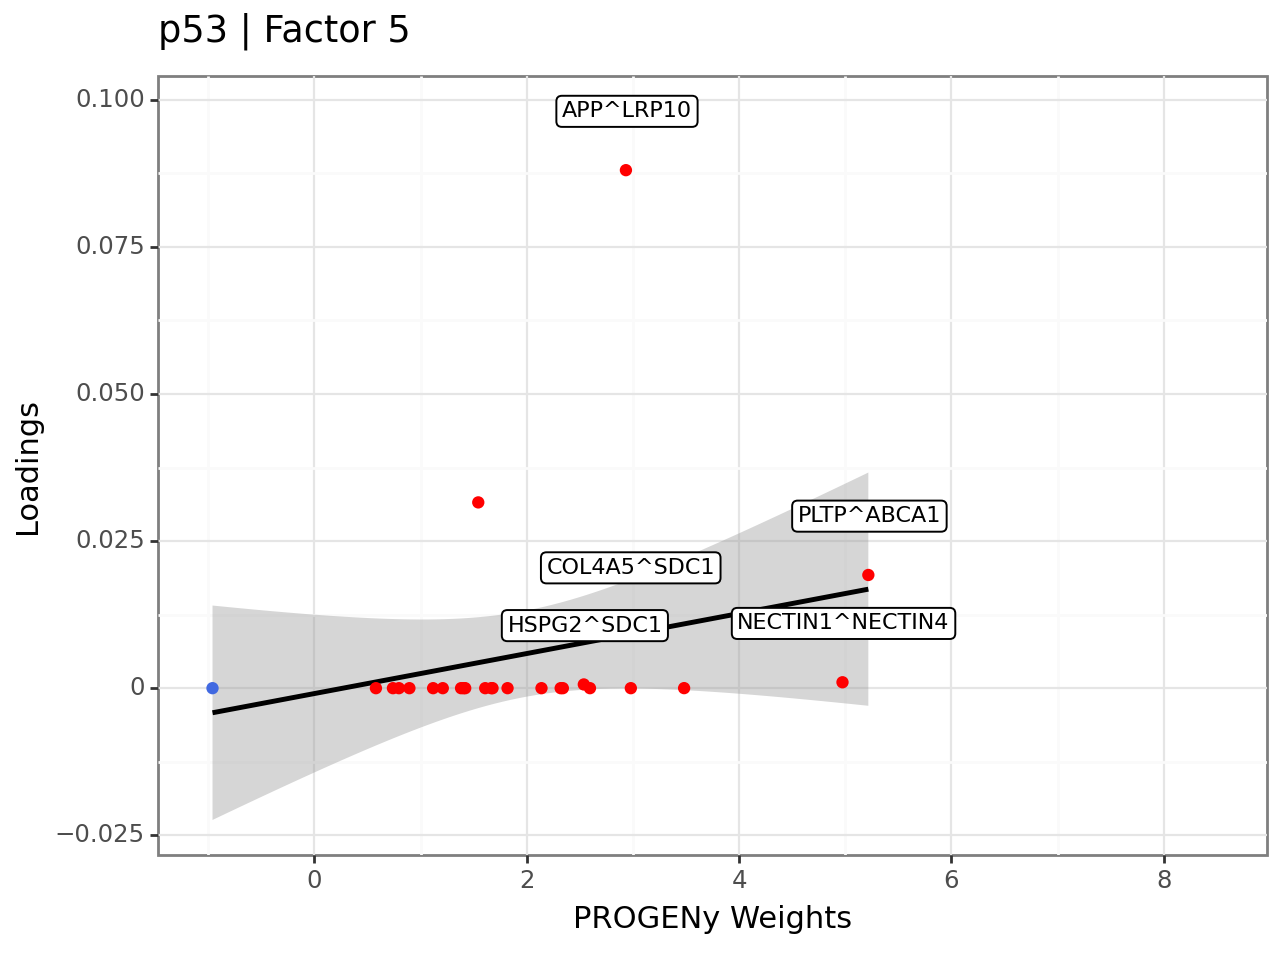

<Figure Size: (640 x 480)>

In [33]:
#select factor of interest
selected_factor = 'Factor 5'
#select pathway of interest
pathway = 'p53'
# loadings to long format
lr_loadings_long = lr_loadings_healthy.reset_index().melt(id_vars='index', var_name="Factor", value_name="Loadings").rename(columns={'index':'interaction'})
# join progeny weights and keep only NFkB pathway
lr_loadings_long = lr_loadings_long.merge(lr_progeny, on='interaction').query("source == '{}' and Factor == '{}'".format(pathway, selected_factor))
# add sign to the weights
lr_loadings_long['sign'] = lr_loadings_long['weight'].apply(lambda x: 'positive' if x > 0 else 'negative')
# keep only relevant interactions for labels
lr_loadings_long['relevant_interactions'] = lr_loadings_long.apply(lambda x: x['interaction'] if (x['Loadings'] > 0.00025) and (x['weight'] > 2.5) else None, axis=1)

(p9.ggplot(lr_loadings_long,
           p9.aes(x='weight', y='Loadings')) +
 p9.geom_smooth(method='lm') +
 p9.geom_point(p9.aes(colour='sign')) +
 p9.theme_bw() +
 p9.theme(legend_position='none') +
 p9.labs(title="{} | {}".format(pathway, selected_factor), x="PROGENy Weights", y="Loadings") +
 p9.scale_colour_manual(values=["royalblue", "red"]) +
 p9.geom_label(p9.aes(label='relevant_interactions'), size=8, nudge_y=0.01, nudge_x=0.01) +
 p9.xlim(-1, 8.5)
 )

### COPD

In [40]:
# Path
file_name = 'final_tensor_compartment_COPD.pkl'
file_path = os.path.join(data_dir, file_name)
# Load
tensor_COPD = unpickle_gpu_tensor(file_path, 'cpu')
tensor_COPD

In [45]:
factors_COPD = tensor_COPD.factors
factors_COPD.keys()

odict_keys(['Contexts', 'Ligand-Receptor Pairs', 'Sender Cells', 'Receiver Cells'])

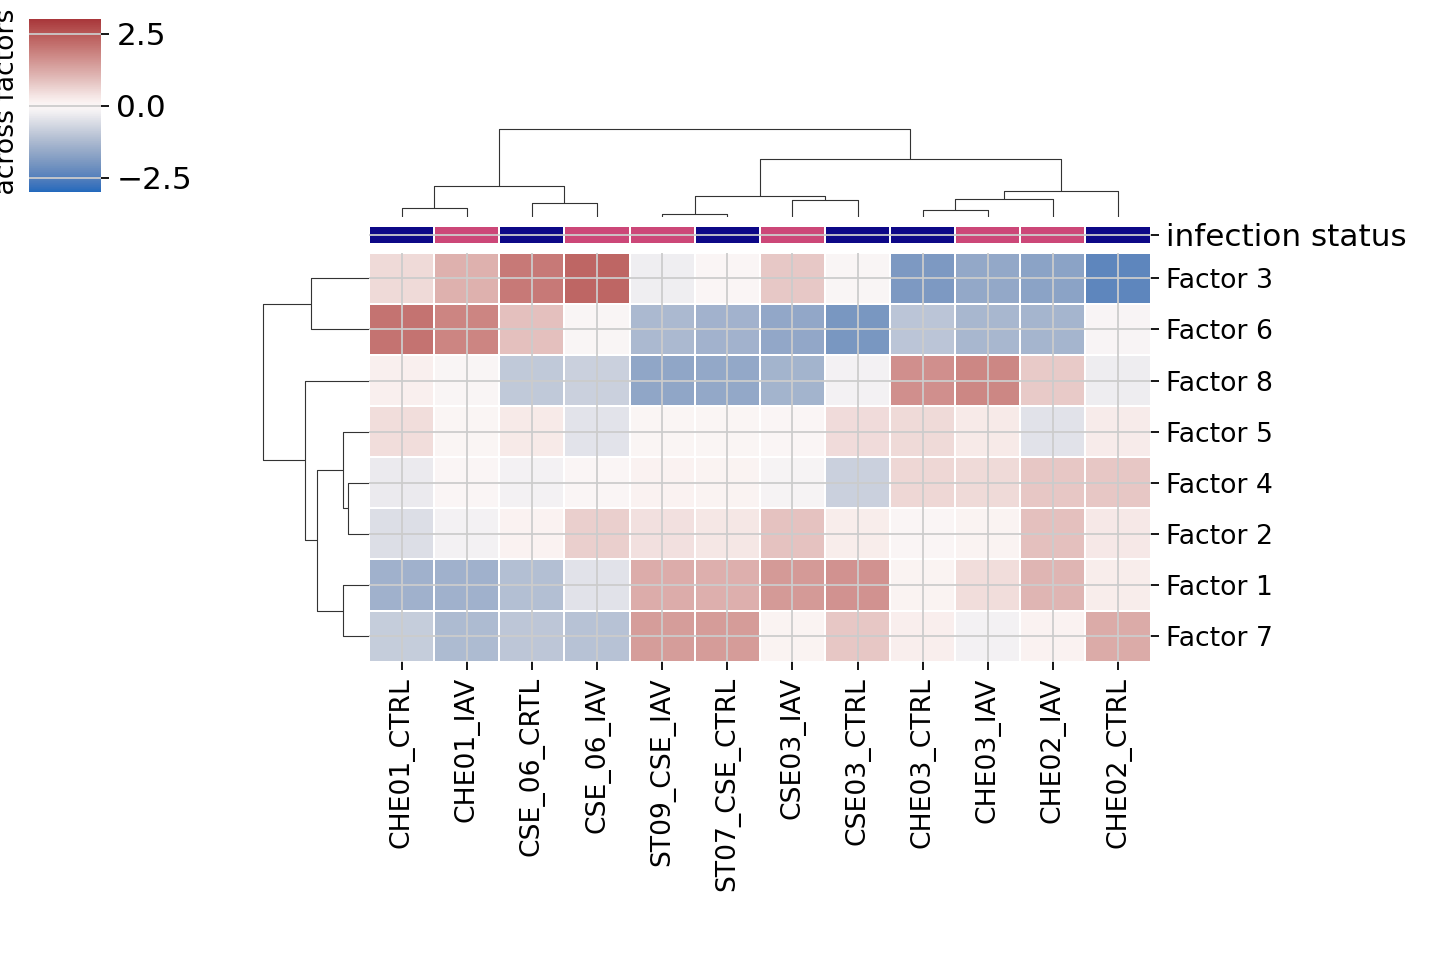

In [46]:
c2c.plotting.loading_clustermap(factors_COPD['Contexts'],
                                use_zscore=True, # Whether standardizing the loadings across factors
                                col_colors=col_colors, # Change this to color by other properties
                                figsize=(9, 6),
                                dendrogram_ratio=0.3,
                                cbar_fontsize=12,
                                tick_fontsize=12
                                )

(<Figure size 640x960 with 8 Axes>,
 array([[<Axes: title={'center': 'Factor 1'}, ylabel='Context Loadings'>,
         <Axes: title={'center': 'Factor 2'}, ylabel=' '>],
        [<Axes: title={'center': 'Factor 3'}, ylabel='Context Loadings'>,
         <Axes: title={'center': 'Factor 4'}, ylabel=' '>],
        [<Axes: title={'center': 'Factor 5'}, ylabel='Context Loadings'>,
         <Axes: title={'center': 'Factor 6'}, ylabel=' '>],
        [<Axes: title={'center': 'Factor 7'}, ylabel='Context Loadings'>,
         <Axes: title={'center': 'Factor 8'}, ylabel=' '>]], dtype=object))

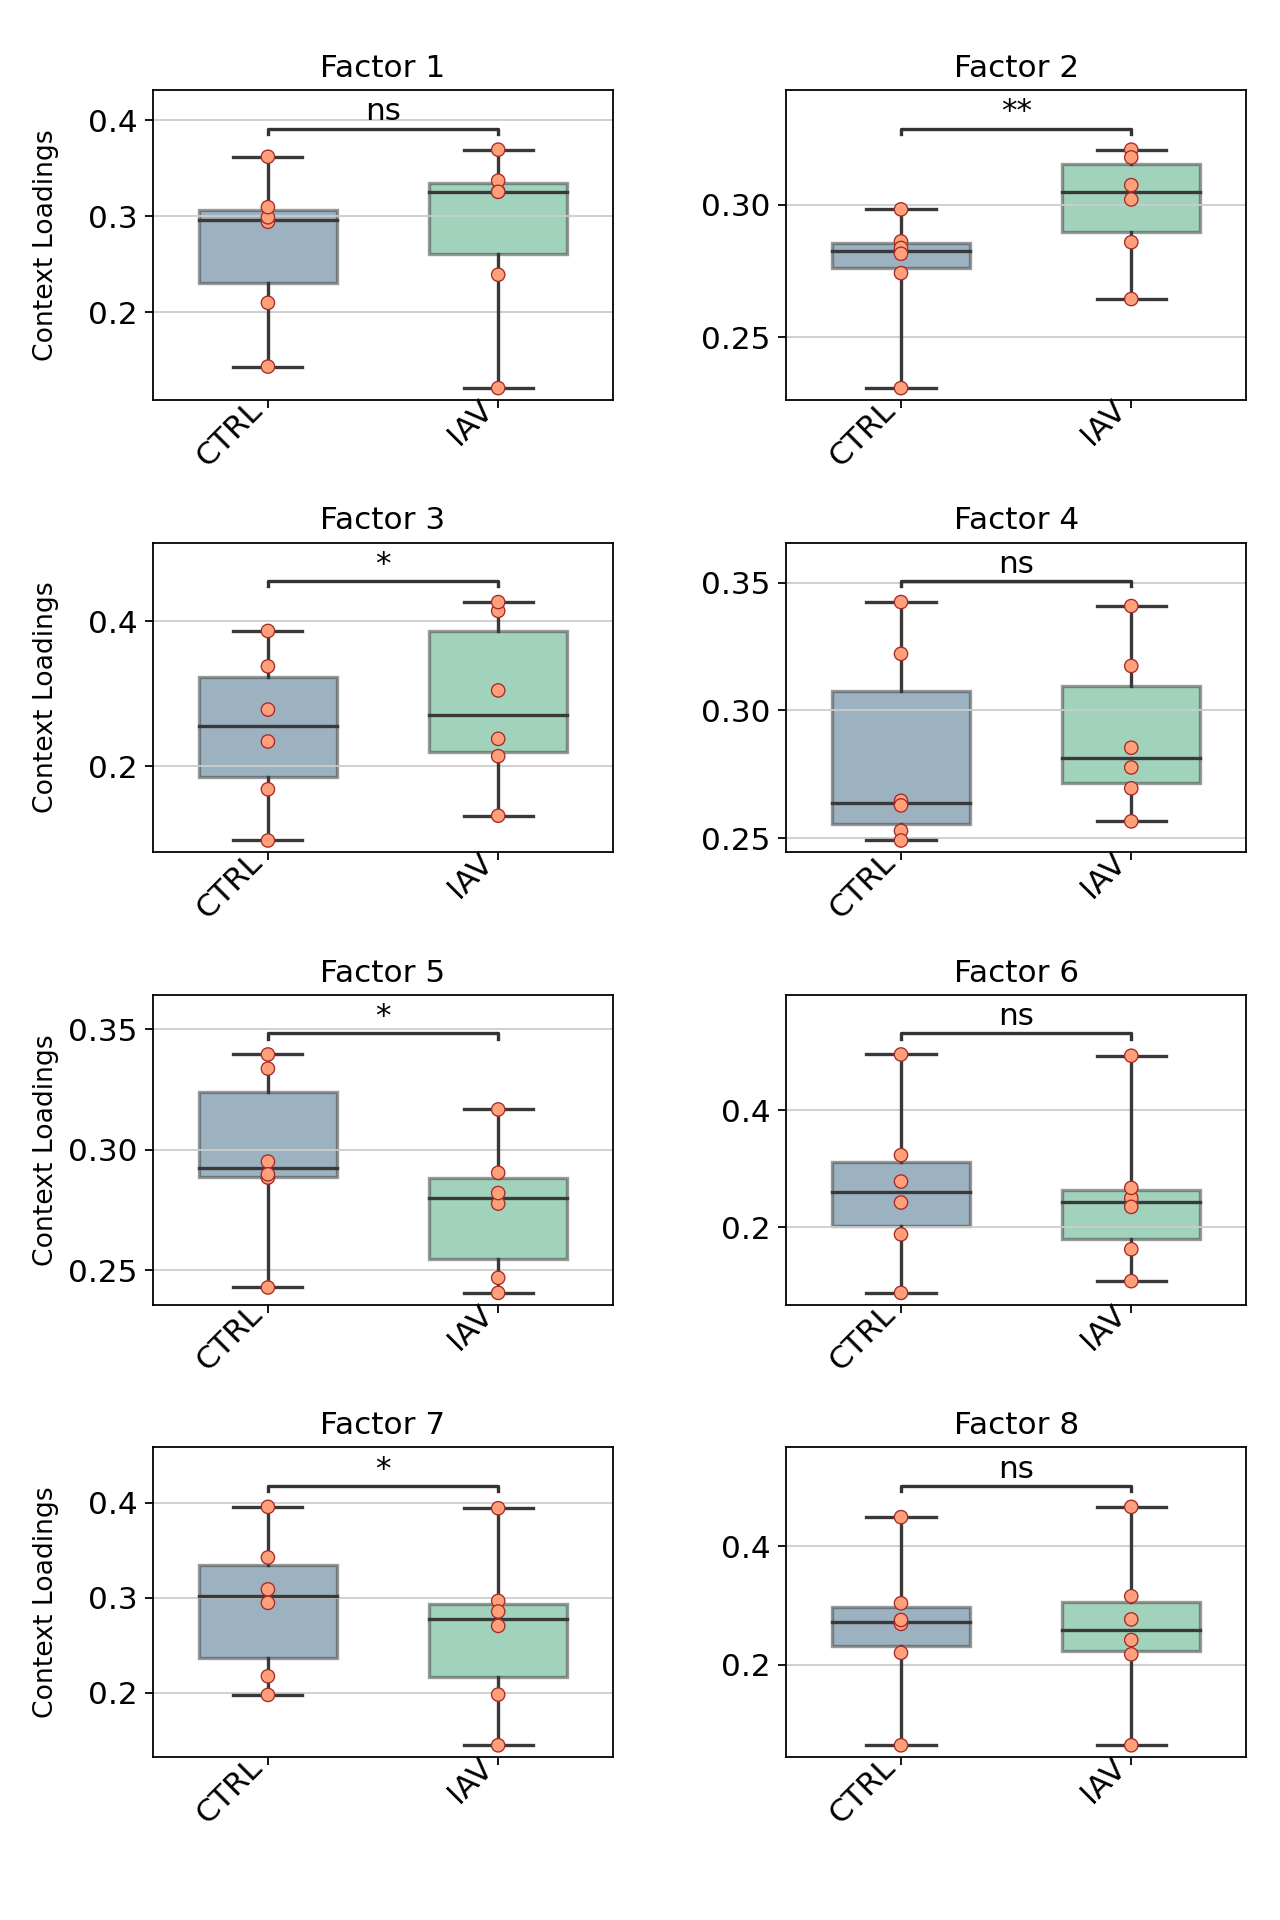

In [47]:
c2c.plotting.factor_plot.context_boxplot(factors_COPD['Contexts'],
                            metadict=context_dict,
                            group_label_rotation= 45,
                            nrows=4,
                            figsize=(8, 12),
                            group_order=['CTRL', 'IAV'],
                            statistical_test='t-test_paired',
                            pval_correction='BH',
                            verbose=False,
                            cmap='viridis',
                            ylabel="Context Loadings",
                            text_format='star'
                            )

(<Figure size 1920x1920 with 9 Axes>,
 array([[<Axes: title={'center': 'Factor 1'}>,
         <Axes: title={'center': 'Factor 2'}>,
         <Axes: title={'center': 'Factor 3'}>],
        [<Axes: title={'center': 'Factor 4'}>,
         <Axes: title={'center': 'Factor 5'}>,
         <Axes: title={'center': 'Factor 6'}>],
        [<Axes: title={'center': 'Factor 7'}>,
         <Axes: title={'center': 'Factor 8'}>, <Axes: >]], dtype=object))

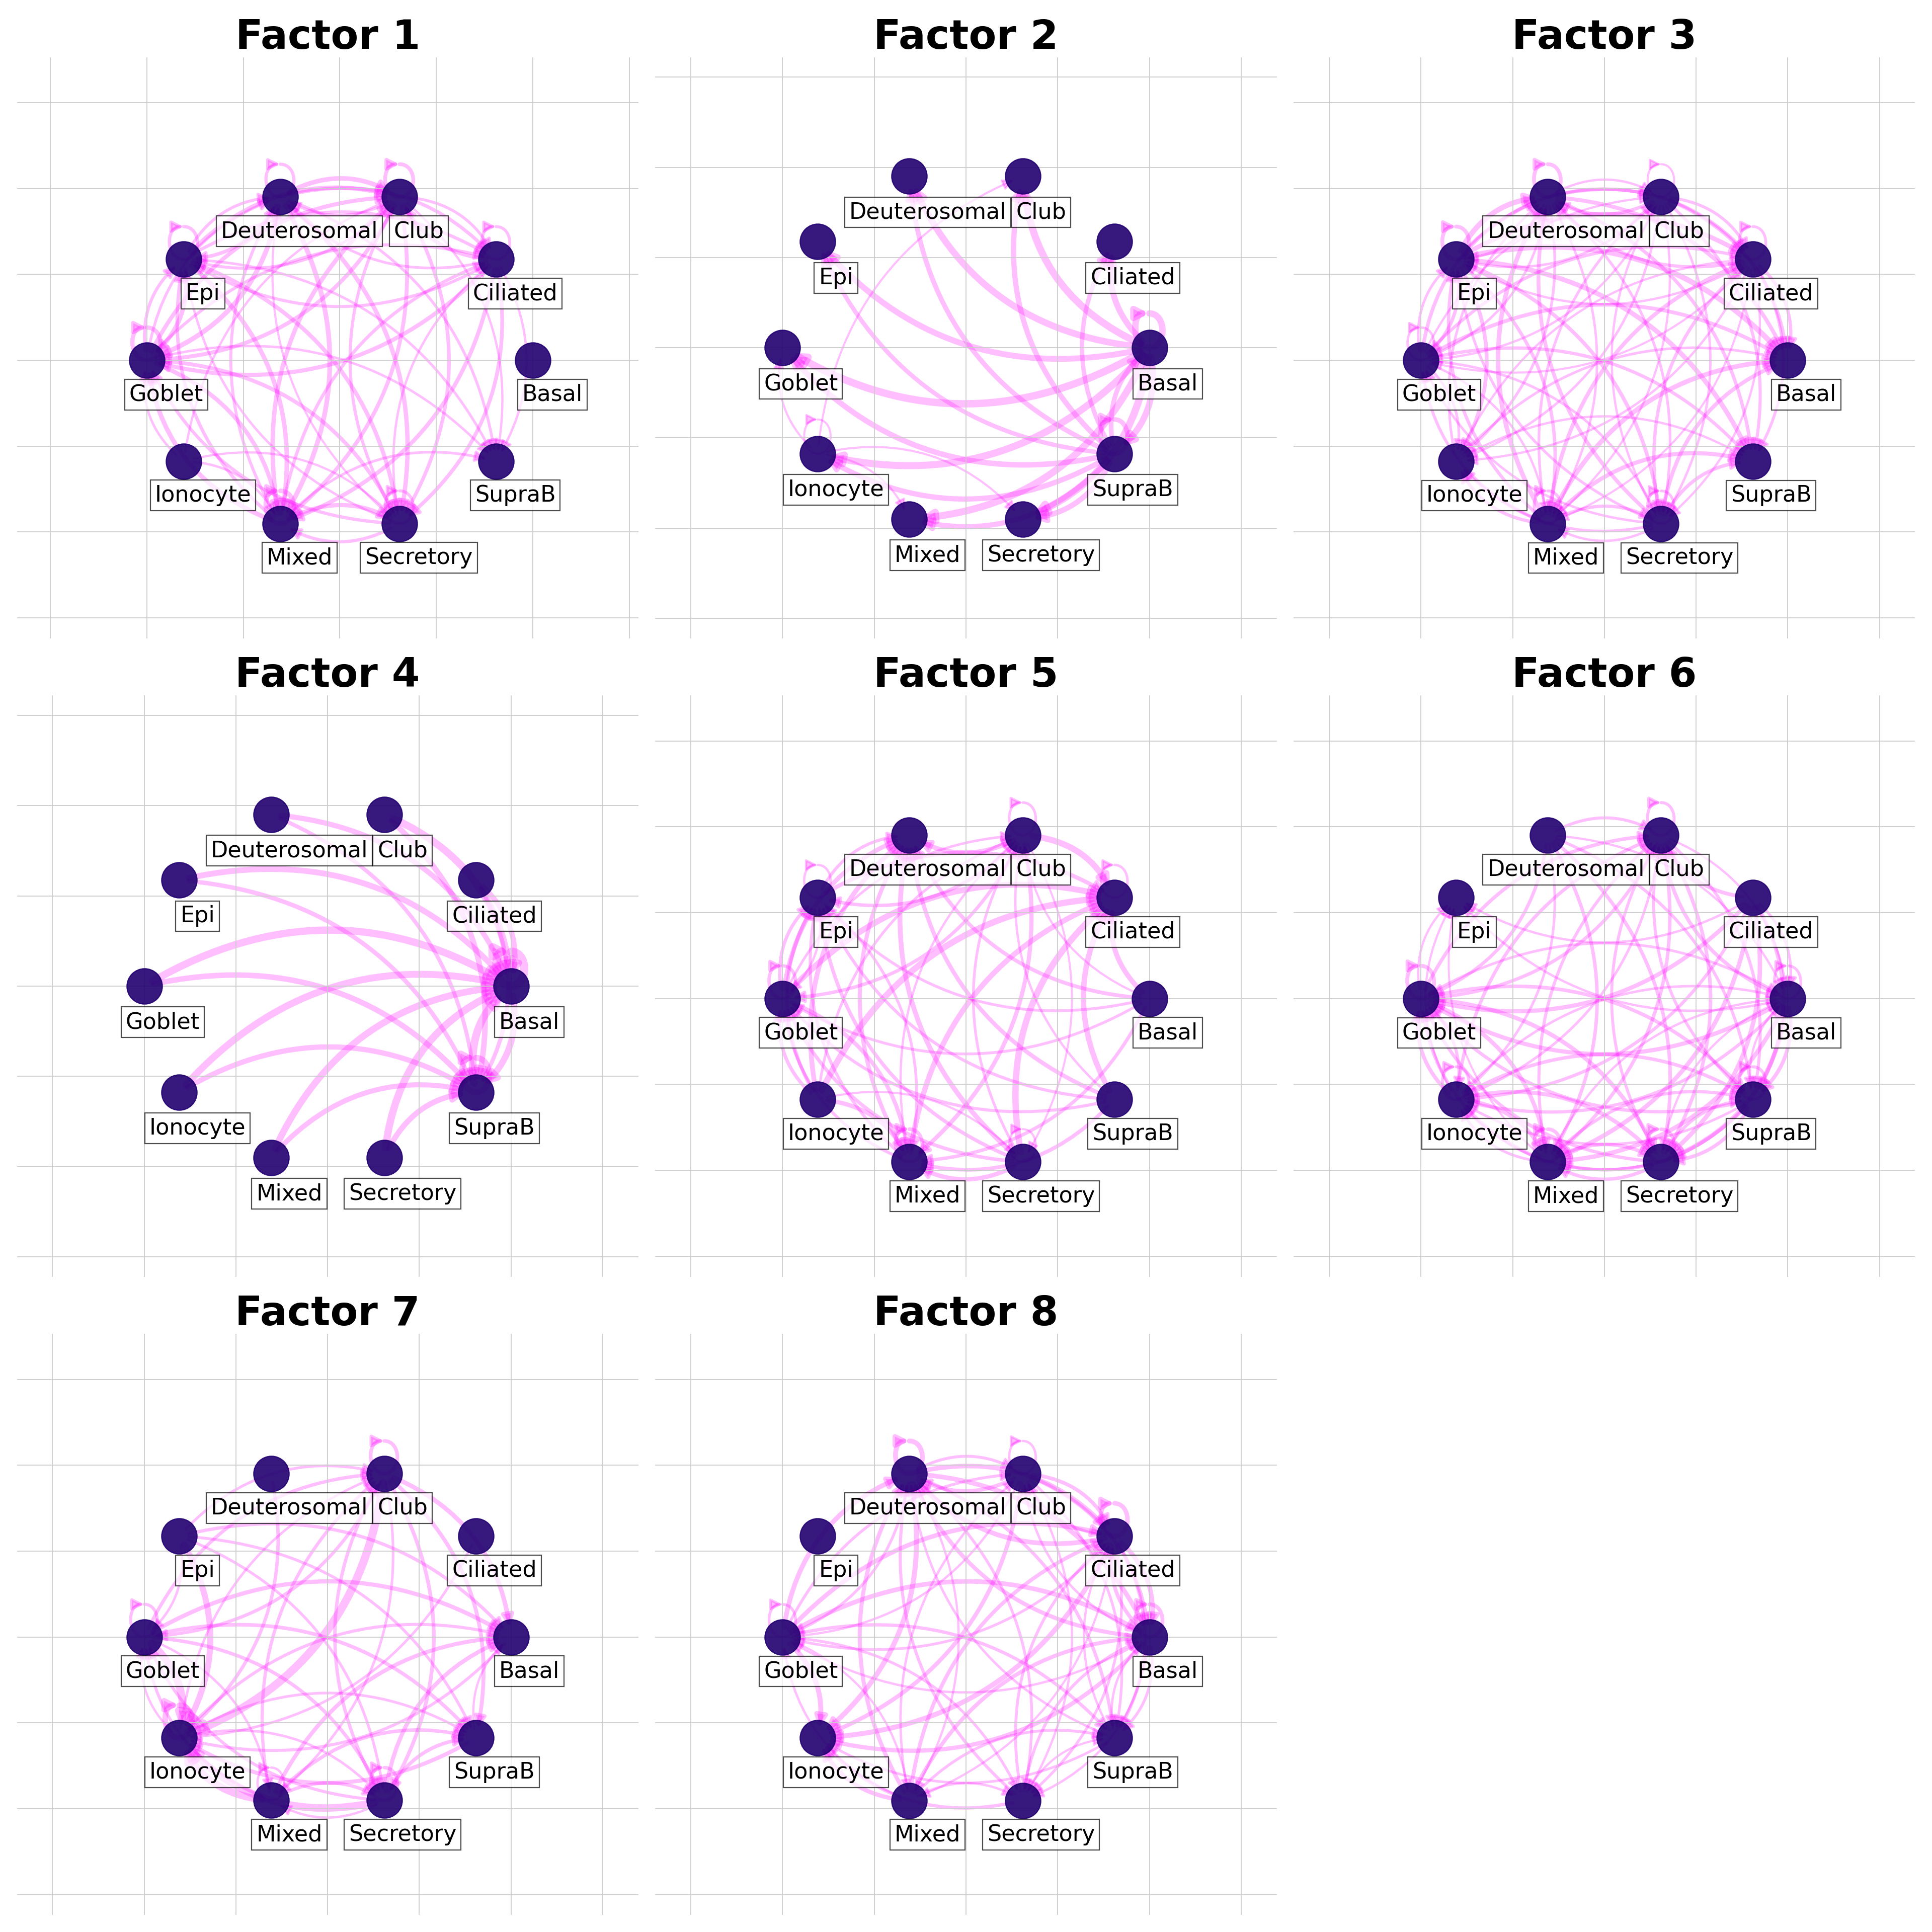

In [50]:
c2c.plotting.ccc_networks_plot(factors_COPD,
                               included_factors=['Factor 1','Factor 2', 'Factor 3','Factor 4','Factor 5', 'Factor 6', 'Factor 7', 'Factor 8'],
                               network_layout='circular',
                               ccc_threshold=0.07, # Only important communication
                               nrows=3,
                               panel_size=(8, 8), # This changes the size of each figure panel.
                              )

In [51]:
factors_COPD

OrderedDict([('Contexts',
                             Factor 1  Factor 2  Factor 3  Factor 4  Factor 5  Factor 6  \
              CHE01_CTRL     0.143361  0.230821  0.337788  0.252876  0.333729  0.495828   
              CHE01_IAV      0.121002  0.264390  0.414127  0.285390  0.290454  0.493677   
              CHE02_CTRL     0.294080  0.298200  0.168638  0.322143  0.295085  0.278205   
              CHE02_IAV      0.325529  0.320713  0.238016  0.317396  0.277632  0.249837   
              CHE03_CTRL     0.298739  0.286130  0.098188  0.342410  0.339594  0.187726   
              CHE03_IAV      0.336838  0.301943  0.132244  0.340852  0.316758  0.162172   
              CSE03_CTRL     0.309276  0.283651  0.278286  0.264598  0.288440  0.242279   
              CSE03_IAV      0.325232  0.307343  0.304653  0.277661  0.282026  0.234783   
              CSE_06_CRTL    0.209735  0.281460  0.386512  0.262806  0.289802  0.323408   
              CSE_06_IAV     0.238964  0.317798  0.426258  0.269

### Computing similarity of factors from the healthy and copd conditions

In [99]:
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

factor_metrics = ['Contexts', 'Sender Cells', 'Receiver Cells']

metric_sims = {}
for metric in factor_metrics:
    print(f'comparing for metric {metric}')
    factor_metric_values_healthy = factors_healthy[metric]
    factor_metric_values_COPD = factors_COPD[metric]
    factors_healthy_name = factor_metric_values_healthy.columns
    factors_COPD_name = factor_metric_values_COPD.columns
    similarities = pd.DataFrame(index=factor_metric_values_healthy.columns, columns=factor_metric_values_COPD.columns)
    for healthy_factor_name in factors_healthy_name:
        for COPD_factor_name in factors_COPD_name:
            factor_values_healthy = factor_metric_values_healthy[healthy_factor_name]
            factor_values_COPD = factor_metric_values_COPD[COPD_factor_name]
            cosine_sim = cosine_similarity(factor_values_healthy, factor_values_COPD)
            similarities.loc[healthy_factor_name, COPD_factor_name] = cosine_sim
    metric_sims[metric] = similarities
 
    

comparing for metric Contexts
comparing for metric Sender Cells
comparing for metric Receiver Cells


In [137]:
def find_max_values(df):
    max_values = df.max(axis=1)
    max_indices = df.idxmax(axis=1)
    result = pd.DataFrame({'Max Value': max_values, 'Row Index': max_indices})
    return result

In [138]:
metric = 'Contexts'
metric_sims[metric] = metric_sims[metric].apply(pd.to_numeric, errors='coerce')
# Get the result
result = find_max_values(metric_sims[metric])
result

Max Value Row Index
Factor 1   0.993249  Factor 5
Factor 2   0.991257  Factor 2
Factor 3   0.993517  Factor 2
Factor 4   0.986862  Factor 2
Factor 5   0.987531  Factor 2
Factor 6   0.974365  Factor 4
Factor 7   0.969488  Factor 8

In [139]:
metric = 'Sender Cells'
metric_sims[metric] = metric_sims[metric].apply(pd.to_numeric, errors='coerce')
# Get the result
result = find_max_values(metric_sims[metric])
result

Max Value Row Index
Factor 1   0.986524  Factor 3
Factor 2   0.994617  Factor 7
Factor 3   0.988483  Factor 2
Factor 4   0.986683  Factor 5
Factor 5   0.889112  Factor 1
Factor 6   0.988726  Factor 4
Factor 7   0.922994  Factor 6

In [140]:
metric = 'Receiver Cells'
metric_sims[metric] = metric_sims[metric].apply(pd.to_numeric, errors='coerce')
# Get the result
result = find_max_values(metric_sims[metric])
result

Max Value Row Index
Factor 1   0.986044  Factor 1
Factor 2   0.905128  Factor 7
Factor 3   0.994492  Factor 2
Factor 4   0.983794  Factor 5
Factor 5   0.997489  Factor 2
Factor 6   0.939278  Factor 4
Factor 7   0.988748  Factor 2

Factor 6 from healthy and Factor 4 from COPD patients appears very similar